# Introduction et problématisation

# Aperçu de la base de données et nettoyage
  ## Installation de tous les packages nécessaires au projet

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from urllib import request
from wordcloud import WordCloud, STOPWORDS 
import csv
import bs4
from tqdm.notebook import trange, tqdm
import seaborn as sns
import numpy as np

In [3]:
!git clone -l -s git://https://github.com/marie-ganon/Projet-Python-S1.git
%cd cloned-repo
!ls

Cloning into 'Projet-Python-S1'...
fatal: Unable to look up https (port 9418) (Name or service not known)
[Errno 2] No such file or directory: 'cloned-repo'
/content
movies_metadata.csv.zip  sample_data


## Aperçu de la base initiale

La base que nous avons décidé de choisir pour mener à bien notre projet est un ensemble de données collecté par TMDB (The Movie Database, une API), ainsi que GroupLens, un laboratoire de recherche de l'université du Minnesota.

Le dataset est disponible à l'adresse suivante : https://www.kaggle.com/rounakbanik/the-movies-dataset.

Ces données regroupent plus de 45 000 films et donnent de nombreuses caractéristiques, tels que le genre, le budget et le revenu généré par le film. Une partie de la base a été prénettoyée sur Excel et avec des méthodes Python simples. 

In [4]:
# On crée un dossier temporaire pour dézipper le csv
import tempfile

temp_dir = tempfile.mkdtemp()


In [5]:
# Pour dezipper le csv disponible dans le git (movies metadata)

import zipfile

with zipfile.ZipFile('movies_metadata.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('temp_dir')
    

In [6]:
df = pd.read_csv(r'temp_dir/movies_metadata.csv', sep=',', low_memory = False)

On regarde tout d'abord si la base comporte beaucoup de cellules vides :

Complétude totale en pourcentage de la base : 90.32592120119062 %


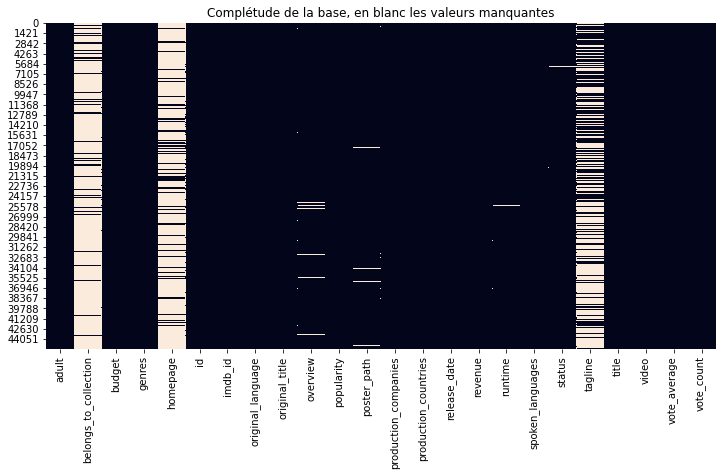

In [7]:
fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(df.isnull(), cbar=False)
plt.title('Complétude de la base, en blanc les valeurs manquantes')
print("Complétude totale en pourcentage de la base :", (1-df.isnull().sum().sum()/(len(df.id)*len(df.columns)))*100,'%')

## Détails des colonnes de la base

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

En explorant les premières colonnes de la base et le site The Movie DataBase, on comprend mieux le sens des colonnes :

- *adult* : Booléen qui indique si oui ou non le film est un film pour adultes
- *belongs_to_collection*
- *budget* : budget de production du film
- *genres* : Genre cinématographique du film
- *homepage* : Lien menant à la page d'accueil du film si elle existe
- *id* : Identifiant du film sur le site The Movie DataBase
- *imdb_id* : Identifiant du film sur le site Internet Movie DataBase
- *original_language* : Langue dans laquelle le film a été tourné
-	*original_title* : Titre originel du film
- *overview* : Synopsis du film
-	*popularity* : Indicateur de la popularité du film
- *poster_path* : Chemin d'accès à l'affiche du film présentée sur la version anglophone de TMDB (si elle existe)
- *production_companies* : Compagnie qui a produit le film
-	*production_countries* : Pays dans lequel le film a été produit
- *release_date* : Date de première sortie du film, donnée sur TMDB
- *revenue*	: Revenus générés par le film selon TMDB
- *runtime*	: Durée du film
- *spoken_languages* : Langues parlées dans la versionn originale du film
- *status* : Indique si le film est sorti ou non
- *tagline* : slogan/phrase d'accroche du film sur la page anglophone de TMDB (si elle existe)
-	*title*	: Titre du film en anglais
- *video*	: Booléen
- *vote_average* : Moyenne des votes (à l'époque où la base a été constituée) sur TMDB
-	*vote_count* : Nombre de votes (à l'époque où la base a été constituée) sur TMDB


# Nettoyage de la base

## Suppression des colonnes non-utilisées

Notre base de données est très volumineuse. Or toutes les colonnes ne nous seront pas utiles pour notre analyse. Par conséquent, pour une question de mémoire nous avons décidé de les supprimer. 

En particulier, les informations données dans la colonne *spoken_languages* étant peu claires, nous préférons enlever cette colonne de notre dataset.

In [9]:
#df = df.drop(columns ='spoken_languages')
df = df.drop(columns=['belongs_to_collection', 'homepage', 'adult'])

## Nettoyage de *popularity*

Sur *The Movie Database* un indicateur de popularité a été construit à la date *t* en prenant en compte les informations suivantes d'après la documentation :
- Nombre de votes
- Nombre de vues 
- Nombre de favoris 
- Nombre de gens ayant le film dans leur "watchlist"
- Date de sortie
- Nombre de votes totaux
- Score des jours précédents

Néanmoins, les détails de la métrique ne sont pas explicités. 

In [10]:
df.popularity.describe()

count     45461
unique    43758
top         0.0
freq         66
Name: popularity, dtype: object

In [11]:
df.popularity.sort_values(ascending=False).head(100)

35587    Beware Of Frost Bites
34313                    9e-06
38576                    9e-06
536                  96.272374
3493                  9.998415
                 ...          
41                     9.87957
7476                  9.877868
10070                 9.875573
2556                  9.874043
12286                 9.867616
Name: popularity, Length: 100, dtype: object

On constate donc qu'une cellule de la colonne est mal codée : on la remplace par un NaN.

In [12]:
df.popularity.iloc[[35587]] = np.NaN

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Ensuite, nous allons classer la colonne *popularity*. Pour cela il faut d'abord convertir les cellules - qui sont des chaînes de caractères - en flottants.

In [13]:
df.popularity = df.popularity.astype('float64')

In [14]:
df.popularity.sort_values(ascending=False).head(100)

30700    547.488298
33356    294.337037
42222    287.253654
43644    228.032744
24455    213.849907
            ...    
41150     31.772396
25390     31.718977
26555     31.626013
24860     31.595940
31072     31.435879
Name: popularity, Length: 100, dtype: float64

In [15]:
df.popularity.describe()

count    45460.000000
mean         2.921478
std          6.005414
min          0.000000
25%          0.385948
50%          1.127685
75%          3.678902
max        547.488298
Name: popularity, dtype: float64

Les 20 meilleurs films selon la popularité : 

In [16]:
df.sort_values(by='popularity', ascending=False)['original_title'].head(20)

30700                                             Minions
33356                                        Wonder Woman
42222                                Beauty and the Beast
43644                                         Baby Driver
24455                                          Big Hero 6
26564                                            Deadpool
26566                      Guardians of the Galaxy Vol. 2
14551                                              Avatar
24351                                           John Wick
23675                                           Gone Girl
24873               The Hunger Games: Mockingjay - Part 1
44274                      War for the Planet of the Apes
26567                          Captain America: Civil War
292                                          Pulp Fiction
26560    Pirates of the Caribbean: Dead Men Tell No Tales
12481                                     The Dark Knight
536                                          Blade Runner
17818         

Complétude des données de popularité ? 

Popularity est complet à  99.98680332556195 %


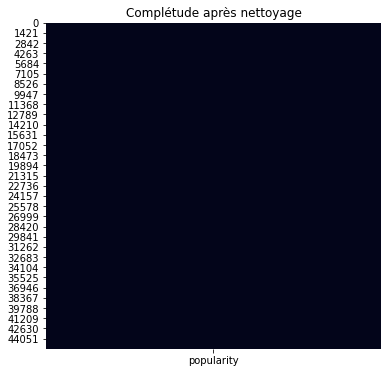

In [17]:
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(df[['popularity']].isnull(),cbar=False)
plt.title('Complétude après nettoyage')
print('Popularity est complet à ',(1-len(df.popularity[df.popularity.isnull()])/len(df.popularity))*100,'%')

## Nettoyage de *vote_average*

Cette colonne correspond à la moyenne des notes données aux films sur TMDB. Ces notes sont comprises entre 0 et 10.

In [18]:
df.vote_average.describe()

count    45460.000000
mean         5.618207
std          1.924216
min          0.000000
25%          5.000000
50%          6.000000
75%          6.800000
max         10.000000
Name: vote_average, dtype: float64

Répartition des notes moyennes

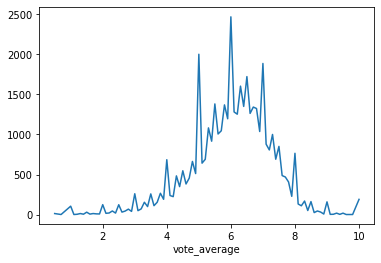

In [19]:
df.groupby(df[df.vote_average > 0]['vote_average']).id.count().plot()

In [20]:
df.sort_values(by='vote_average', ascending=False)['original_title'].head(20)

21642    Ice Age Columbus: Who Were the First Americans?
15710          If God Is Willing and da Creek Don't Rise
22396                                     Meat the Truth
22395              Marvin Hamlisch: What He Did For Love
35343                         Elaine Stritch: At Liberty
186                                             Reckless
45047                                 El auge del humano
22377                                          Ο Ξεναγός
22346                                     هیچ کجا هیچ کس
1634                            Other Voices Other Rooms
35461                            Tom Brown's School Days
22255                                    Cowboy del Amor
45005                                         Fool's Day
41879                     Panorama of Esplanade by Night
41845                                          Maula Jat
40431                                People of a Feather
40442                                Siccin 3: Cürmü Ask
27908                          

En se basant sur les moyennes des notes seules on observe sans surprise un résultat très différent pour la liste des 20 meilleurs films puisque ces moyennes ne prennent pas en compte le poids du nombre de votes. 

## Nettoyage de *vote_count*

In [21]:
df.vote_count.describe()

count    45460.000000
mean       109.897338
std        491.310374
min          0.000000
25%          3.000000
50%         10.000000
75%         34.000000
max      14075.000000
Name: vote_count, dtype: float64

On peut essayer d'établir une métrique permettant d'améliorer l'observation du succès d'un film basé sur sa note. 

*vote_count* $ \times $ *vote_average* 

In [22]:
df['score_1'] = df.vote_count.mul(df.vote_average)

df.sort_values(by='score_1', ascending=False)['original_title'].head(20)

15480                                            Inception
12481                                      The Dark Knight
22879                                         Interstellar
17818                                         The Avengers
14551                                               Avatar
26564                                             Deadpool
2843                                            Fight Club
20051                                     Django Unchained
23753                              Guardians of the Galaxy
292                                           Pulp Fiction
2458                                            The Matrix
4863     The Lord of the Rings: The Fellowship of the Ring
314                               The Shawshank Redemption
18252                                The Dark Knight Rises
26553                                   Mad Max: Fury Road
351                                           Forrest Gump
7000         The Lord of the Rings: The Return of the Ki

Cette première métrique a un résultat correspondant davantage à l'idée que l'on se fait d'un succès critique et commercial d'un film. 

In [23]:
df['score_2'] = df.vote_count.mul(df.vote_average.pow(2))
df['score_3'] = df.vote_count.pow(2).mul(df.vote_average)

l_score1 = df.sort_values(by='score_1', ascending=False)['original_title'].head(20).tolist()
l_score2 = df.sort_values(by='score_2', ascending=False)['original_title'].head(20).tolist()
l_score3 = df.sort_values(by='score_3', ascending=False)['original_title'].head(20).tolist()

pd.DataFrame({'score_1': l_score1 ,'score_2' : l_score2, 'score_3' : l_score3})

score_1  ...                                            score_3
0                                           Inception  ...                                          Inception
1                                     The Dark Knight  ...                                    The Dark Knight
2                                        Interstellar  ...                                       The Avengers
3                                        The Avengers  ...                                             Avatar
4                                              Avatar  ...                                       Interstellar
5                                            Deadpool  ...                                           Deadpool
6                                          Fight Club  ...                                   Django Unchained
7                                    Django Unchained  ...                            Guardians of the Galaxy
8                             Guardians of the Galaxy  ...                                         Fight Club
9                                        Pulp Fiction  ...                                 Mad Max: Fury Road
10                                         The Matrix  ...                              The Dark Knight Rises
11  The Lord of the Rings: The Fellowship of the Ring  ...                                         The Matrix
12                           The Shawshank Redemption  ...                                   The Hunger Games
13                              The Dark Knight Rises  ...  The Lord of the Rings: The Fellowship of the Ring
14                                 Mad Max: Fury Road  ...                                       Pulp Fiction
15                                       Forrest Gump  ...                           The Shawshank Redemption
16      The Lord of the Rings: The Return of the King  ...                                           Iron Man
17                                   The Hunger Games  ...      The Lord of the Rings: The Return of the King
18                                           Iron Man  ...                                         Iron Man 3
19              The Lord of the Rings: The Two Towers  ...                                       Forrest Gump

[20 rows x 3 columns]

On observe d'ailleurs que l'on peut jouer sur l'importance de la popularité via le *vote_count* et sur l'importance du succès critique via *vote_average* : le *score_3* met en avant des films "populaires" au sens blockbusters etc. tandis que le *score_2* met en avant des succès critiques tels que Fight Club, ou The Shawshank Redemption.  Toutefois cette influence est assez marginale, les scores 1, 2 et 3 sont assez proches, on retiendra donc seulement le score 1. 

In [24]:
df['popscore'] = df.vote_count.mul(df.vote_average).mul(df.popularity).pow(2)

l_pop = df.sort_values(by='popularity', ascending=False)['original_title'].head(20).tolist()
l_popscore = df.sort_values(by='popscore', ascending=False)['original_title'].head(20).tolist()
pd.DataFrame({'popularity': l_pop ,'score_1' : l_score1, 'pop_score': l_popscore})


popularity  ...                              pop_score
0                                            Minions  ...                                Minions
1                                       Wonder Woman  ...                                 Avatar
2                               Beauty and the Beast  ...                               Deadpool
3                                        Baby Driver  ...                        The Dark Knight
4                                         Big Hero 6  ...                   Beauty and the Beast
5                                           Deadpool  ...                           Wonder Woman
6                     Guardians of the Galaxy Vol. 2  ...                             Big Hero 6
7                                             Avatar  ...                           Pulp Fiction
8                                          John Wick  ...                           The Avengers
9                                          Gone Girl  ...             Captain America: Civil War
10             The Hunger Games: Mockingjay - Part 1  ...                              Gone Girl
11                    War for the Planet of the Apes  ...                              John Wick
12                        Captain America: Civil War  ...         Guardians of the Galaxy Vol. 2
13                                      Pulp Fiction  ...  The Hunger Games: Mockingjay - Part 1
14  Pirates of the Caribbean: Dead Men Tell No Tales  ...                             Fight Club
15                                   The Dark Knight  ...                Guardians of the Galaxy
16                                      Blade Runner  ...               The Shawshank Redemption
17                                      The Avengers  ...                            Baby Driver
18          Captain Underpants: The First Epic Movie  ...                              Inception
19                                        The Circle  ...                           Forrest Gump

[20 rows x 3 columns]

En comparant *popularity* et *score_1* on voit d'ailleurs que des films étant des réussites commerciales (films d'animation souvent) n'apparaissent pas dans le top 20 avec le score. Avec le score mélangeant popularité et score 1, on arrive à trouver un compromis entre les deux. 

## Nettoyage de *production_companies* 

In [25]:
df.production_companies

0           [{'name': 'Pixar Animation Studios', 'id': 3}]
1        [{'name': 'TriStar Pictures', 'id': 559}, {'na...
2        [{'name': 'Warner Bros.', 'id': 6194}, {'name'...
3        [{'name': 'Twentieth Century Fox Film Corporat...
4        [{'name': 'Sandollar Productions', 'id': 5842}...
                               ...                        
45461                                                   []
45462               [{'name': 'Sine Olivia', 'id': 19653}]
45463    [{'name': 'American World Pictures', 'id': 6165}]
45464                 [{'name': 'Yermoliev', 'id': 88753}]
45465                                                   []
Name: production_companies, Length: 45466, dtype: object

Dans la cellule de code suivante, nous allons récupérer les noms des companies de production, ainsi que leur identifiant. Celui-ci s'avérera utile par la suite.

In [26]:
df_temp = df.production_companies.str.split(',')
df_1 = pd.DataFrame()
df_2 = pd.DataFrame()
df_1['name'] = df_temp.str.get(0)
df_1['id'] = df_temp.str.get(1)
df['production_companies_name'] = df_1.name.str.split(':').str.get(1)
df_2['production_companies_id'] = df_1.id.str.split(':').str.get(1)


In [27]:
import re
l = []
for elem in df_2['production_companies_id']:
  string1 = str(elem)
  l.append(map(int, re.findall(r'\d+', string1)))
df['production_companies_id']= pd.DataFrame(l)


In [28]:
df.production_companies_name

0                        'Pixar Animation Studios'
1                               'TriStar Pictures'
2                                   'Warner Bros.'
3         'Twentieth Century Fox Film Corporation'
4                          'Sandollar Productions'
                           ...                    
45461                                          NaN
45462                                'Sine Olivia'
45463                    'American World Pictures'
45464                                  'Yermoliev'
45465                                          NaN
Name: production_companies_name, Length: 45466, dtype: object

On retire ensuite les guillemets qui se trouvent dans les cellules de cette colonne.

In [29]:
df.production_companies_name = df.production_companies_name.str.replace(r'[^\w\s]+', '')
#df.production_companies_id= df.production_companies_id.str.replace(r'[^\w\s]+', '')

In [30]:
#fig, ax = plt.subplots(figsize=(15,25))
#sns.countplot(y = df.production_companies_name, data = df, order =df.production_companies_name.value_counts().iloc[:100].index)
#ax.set_xscale('log')
#plt.title('Occurrences des 500 premières entreprises de production')

Nous pouvons remarquer quelques effets à corriger : certains films sont mal regroupés en raison de l'utilisation des acronymes ou du nom complet de la société de production. Par exemple, Lionsgate  est également présent sous le nom Lions Gate, de même avec la BBC et British Broadcasting Channel etc. 

Une façon de contourner ce problème est de lier les noms aux id. 

In [31]:
df.production_companies_id.describe()

count    33402.000000
mean     10582.189540
std      18087.974359
min          1.000000
25%        512.000000
50%       3929.500000
75%      10285.000000
max      96067.000000
Name: production_companies_id, dtype: float64

In [32]:
#fig, ax = plt.subplots(figsize=(15,25))
#sns.countplot(y = df.production_companies_id, data = df, order =df.production_companies_id.value_counts().iloc[:100].index)
#ax.set_xscale('log')
#plt.title('Occurrences des 500 premières entreprises de production')

## Nettoyage de *production_countries*

Là encore, grâce à la fonction split(), nous pouvons conserver uniquement ce qui nous intéresse, ici le pays de production du film.

In [33]:
df.production_countries.str.split(',').str.get(1)

0         'name': 'United States of America'}]
1         'name': 'United States of America'}]
2         'name': 'United States of America'}]
3         'name': 'United States of America'}]
4         'name': 'United States of America'}]
                         ...                  
45461                         'name': 'Iran'}]
45462                  'name': 'Philippines'}]
45463     'name': 'United States of America'}]
45464                       'name': 'Russia'}]
45465               'name': 'United Kingdom'}]
Name: production_countries, Length: 45466, dtype: object

In [34]:
df_temp = df.production_countries.str.split(',')
df_1 = pd.DataFrame()
df_2 = pd.DataFrame()
df_1['country_code'] = df_temp.str.get(0)
df_1['country_name'] = df_temp.str.get(1)
df['country_code'] = df_1.country_code.str.split(':').str.get(1)
df_2['country_name_try'] = df_1.country_name.str.split(':').str.get(1)
df['country_name']=df_2['country_name_try'].str.split('}').str.get(0)

df.country_code = df.country_code.str.replace(r'[^\w\s]+', '')
df.country_name = df.country_name.str.replace(r'[^\w\s]+', '')

On supprime alors les colonnes dédoublées lors du nettoyage. 

In [35]:
df = df.drop(columns=['production_companies','production_countries'])

In [36]:
#fig, ax = plt.subplots(figsize=(15,25))
#sns.countplot(y = df.country_name.sort_values())
#ax.set_xscale('log')
#plt.title('Occurrences totales des pays de production')

La variable *country_name* est suffisamment propre. Intéressons-nous à sa complétude.

Country_name est complet à  86.16988518893238 %


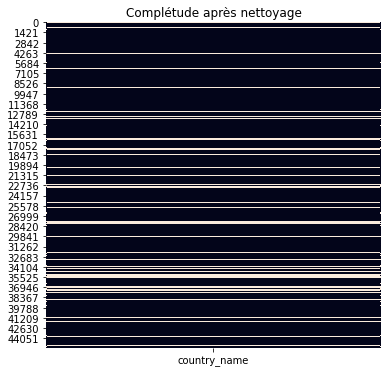

In [37]:
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(df[['country_name']].isnull(),cbar=False)
plt.title('Complétude après nettoyage')
print('Country_name est complet à ',(1-len(df.country_name[df.country_name.isnull()])/len(df.country_name))*100,'%')

Nous remarquons que conserver certains mots dans les cellules de la base, tels que les 'id', 'name', ne sont pas pertinents. Par ailleurs, il sera plus lisible de pouvoir associer les identifiants de langue ISO_639-1 à leur langue dans la colonne *original_language*. Ces deux objectifs sont l'objet des sections suivantes.




## Nettoyage de la variable *original_language*

Dans notre base de données, les langues originales dans lequel le film est apparu sont codées de cette manière :

In [38]:
df.original_language[0]

'en'

En fait, il s'agit des identifiants ISO_639-1 de chaque langue (en l'occurence ici l'anglais). Pour plus de lisibilité, nous avons décidé de récupérer cette liste d'identifiants via une méthode de webscrapping, puis de créer une fonction qui renvoit la langue associée à son identifiant.

### Scraping de la liste ISO_639-1

La liste des codes IS0_639-1 est disponible sur l'url suivante : https://fr.wikipedia.org/wiki/Liste_des_codes_ISO_639-1.

Nous allons récupérer les identifiants, ainsi que les langues correspondantes:

In [39]:
url_iso = "https://fr.wikipedia.org/wiki/Liste_des_codes_ISO_639-1"
    
request_text = request.urlopen(url_iso).read()
page = bs4.BeautifulSoup(request_text, "lxml")

Les informations que nous désirons étant contenues dans un tableau, on le récupère puis on le convertit en Data Frame.

In [40]:
table = page.find('table')
ls = str(table)
liste_iso = pd.DataFrame(pd.read_html(ls)[0])
liste_iso

639-1    639-2  ... Nom en anglais Commentaire
0      aa      aar  ...           Afar         NaN
1      ab      abk  ...      Abkhazian         NaN
2      ae      ave  ...        Avestan         NaN
3      af      afr  ...      Afrikaans         NaN
4      ak      aka  ...           Akan         NaN
..    ...      ...  ...            ...         ...
182    yi      yid  ...        Yiddish         NaN
183    yo      yor  ...         Yoruba         NaN
184    za      zha  ...         Zhuang         NaN
185    zh  chi/zho  ...        Chinese         NaN
186    zu      zul  ...           Zulu         NaN

[187 rows x 7 columns]

Après une étude approfondie de la base, nous avons constaté que certains films possédaient l'identifiant 'cn' correspondant au cantonais. On le rajoute au Data Frame précédent: 

In [41]:
liste_iso.loc[187] = ['cn', 'NaN', 'NaN', 'Cantonais', 'NaN', 'Cantonese', 'NaN']
liste_iso

639-1    639-2  ... Nom en anglais Commentaire
0      aa      aar  ...           Afar         NaN
1      ab      abk  ...      Abkhazian         NaN
2      ae      ave  ...        Avestan         NaN
3      af      afr  ...      Afrikaans         NaN
4      ak      aka  ...           Akan         NaN
..    ...      ...  ...            ...         ...
183    yo      yor  ...         Yoruba         NaN
184    za      zha  ...         Zhuang         NaN
185    zh  chi/zho  ...        Chinese         NaN
186    zu      zul  ...           Zulu         NaN
187    cn      NaN  ...      Cantonese         NaN

[188 rows x 7 columns]

### Nettoyage de la colonne

La fonction suivante permettra de récupérer la langue associée à un identifiant ISO_639-1. En la faisant tourner, nous nous sommes rendu compte que les NaN n'étaient pas toujours indiqués de la même manière. Il faut donc prendre en compte ces cas pour éviter toute erreur lors du lancement de la fonction.

In [42]:
def find_id(id):
  if id == '' or id == 'NaN' or id == 'xx' or id == 'nan' or id =='104.0' or id =='68.0' or id =='82.0':        # on élimine le cas où la langue n'est pas indiquée
    return ''
  i = 0
  while (str((liste_iso['639-1'])[i]) == id) == False and i<len(df):
    i += 1
  return liste_iso['Nom de la langue'][i]

On teste la fonction sur la première entrée de la colonne 'original_language'

In [43]:
test = str('en')
find_id(test)

'Anglais'

Puis on généralise la méthode à toutes les cellules de cette colonne :

In [44]:
for i in trange(len(df)):
  id = str(df.original_language[i])
  df.original_language[i] = find_id(id)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [45]:
df.original_language

0        Anglais
1        Anglais
2        Anglais
3        Anglais
4        Anglais
          ...   
45461     Persan
45462    Tagalog
45463    Anglais
45464    Anglais
45465    Anglais
Name: original_language, Length: 45466, dtype: object

## Nettoyage de *genre* 

Le but de cette partie est de supprimer les caractères non-essentiels qui se trouvent dans les cellules de cette colonne, tels que les id et les name.

In [46]:
df.genres = df.genres.str.replace(r'[^\w\s]+', '')
df.genres[0]

'id 16 name Animation id 35 name Comedy id 10751 name Family'

Dans cet exemple, il nous faut seulement les mots *Animation*, *Comedy* et *Family*. Grâce à la fonction split(), nous pouvons transformer cette chaîne de caractère en liste, puis récupérer les mots qui nous intéressent. Le code suivant réalise cette opération pour toutes les cellules de cette colonne


In [47]:
for i in trange(len(df)):
  genre = df.genres[i].split()
  df.genres[i] = ""
  for j in range(len(genre)//4):
    if j == 0 :
      df.genres[i] = df.genres[i] + genre[3]
    else : 
      df.genres[i] = df.genres[i] + ', ' + genre[3 + j*4]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [48]:
df.genres

0         Animation, Comedy, Family
1        Adventure, Fantasy, Family
2                   Romance, Comedy
3            Comedy, Drama, Romance
4                            Comedy
                    ...            
45461                 Drama, Family
45462                         Drama
45463       Action, Drama, Thriller
45464                              
45465                              
Name: genres, Length: 45466, dtype: object

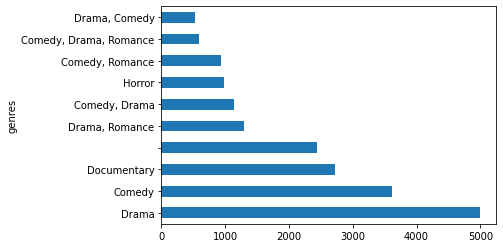

In [49]:
df.groupby(df['genres']).id.count().sort_values(ascending = False)[:10].plot(kind = 'barh')

Les films de genre *drame*, *comédie* et *documentaire* sont les plus représentés dans l'ensemble des films. Remarquons que les genres n'ont pas été récupérés indépendamment : on considère comme un genre à part entière des subsets composés de plusieurs genres. On pourrait vouloir voir la proportion des films contenant *Drama* ou *Romance* par exemple.

In [50]:
l = []
for i in trange(len(df)):
    genre = df.genres[i].split()
    for i in genre :
        l.append(i)
genre = pd.DataFrame(l, columns=['genre'])
genre = genre.genre.str.replace(r',', '')
genre

0        Animation
1           Comedy
2           Family
3        Adventure
4          Fantasy
           ...    
91104       Family
91105        Drama
91106       Action
91107        Drama
91108     Thriller
Name: genre, Length: 91109, dtype: object

Text(0.5, 1.0, 'Occurrences totales des genres')

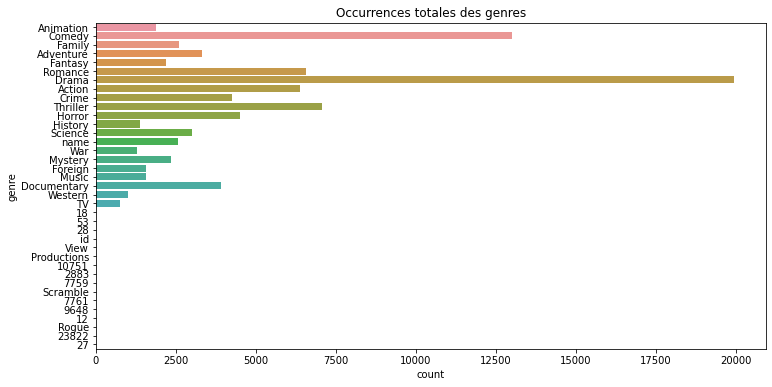

In [51]:
fig, ax = plt.subplots(figsize=(12,6))
sns.countplot(y = genre)
plt.title('Occurrences totales des genres')

Ces premières statistiques descriptives nous font apparaître que la base n'est pas bien nettoyée puiqu'il reste des id et des entrées qui ne correspondent pas au genre. 

In [52]:
df.genres[df.genres.notnull()].sort_values()

45465                                       
21814                                       
21818                                       
21836                                       
21853                                       
                        ...                 
22157                      Western, Thriller
36003                           Western, War
7989          Western, War, History, Romance
35587    id, Productions, Rogue, name, 23822
19730            id, View, name, Productions
Name: genres, Length: 45466, dtype: object

In [53]:
df.at[35587,'genres'] = ''
df.at[19730, 'genres'] = ''
df.genres = df.genres.str.replace('name','')
df.genres = df.genres.str.replace('Productions', '')
df.genres = df.genres.str.replace('18','')
df.genres = df.genres.str.replace('53','')
df.genres = df.genres.str.replace('28','')
df.genres = df.genres.str.replace('id','')
df.genres = df.genres.str.replace('View','')
df.genres = df.genres.str.replace('10751','')
df.genres = df.genres.str.replace('2883','')
df.genres = df.genres.str.replace('7759','')
df.genres = df.genres.str.replace('7761','')
df.genres = df.genres.str.replace('9648','')
df.genres = df.genres.str.replace('12','')
df.genres = df.genres.str.replace('23822','')
df.genres = df.genres.str.replace('27','')
df.genres = df.genres.str.replace('83','')
df.genres = df.genres.str.replace('Scramble','')

Une fois nettoyée : 


89391


Text(0.5, 1.0, 'Occurrences totales des genres')

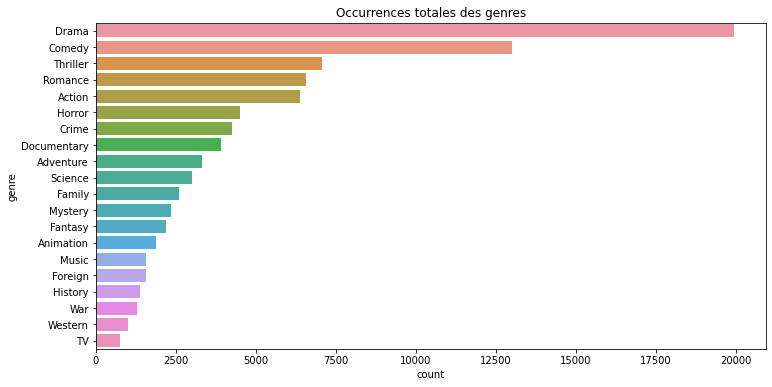

In [54]:
l = []
for i in trange(len(df)):
    genre = df.genres[i].split()
    for i in genre :
        l.append(i)
print(len(l))
df_genre = pd.DataFrame(l, columns=['genre'])
df_genre.genre = df_genre.genre.str.replace(r',', '')
df_genre.genre = df_genre[df_genre.genre != '']
fig, ax = plt.subplots(figsize=(12,6))
sns.countplot(y = df_genre.genre, order = df_genre['genre'].value_counts().index)
plt.title('Occurrences totales des genres')


Ce nettoyage fait apparaître qu'il existe en fait des genres plus représentés que Documentaire mais qui figuraient souvent dans des regroupements (Thriller, Action, Horror ou Crime). 

Qu'en est-il de la complétude après nettoyage ? 

In [55]:
len(df.genres[df.genres == ''])
df.genres = df.genres.replace('', np.NaN)

Genres est complet à  94.62455461223772 %


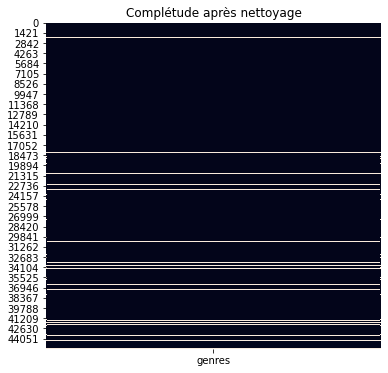

In [56]:
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(df[['genres']].isnull(),cbar=False)
plt.title('Complétude après nettoyage')
print('Genres est complet à ',(1-len(df.genres[df.genres.isnull()])/len(df.genres))*100,'%')

## Nettoyage de la variable *budget*

In [57]:
df.budget.sort_values()

19730    /ff9qCepilowshEtG2GYWwzt2bs4.jpg
29503    /zV8bHuSL6WXoD6FWogP9j4x80bL.jpg
35587    /zaSf5OG7V8X8gqFvly88zDdRm46.jpg
45465                                   0
26992                                   0
                       ...               
39688                             9900000
34215                            99000000
11609                              994000
39203                              996519
9247                               998000
Name: budget, Length: 45466, dtype: object

Certaines cellules de cette colonne ne comportant pas d'information pertinente sur le budget du film, on va les considérer comme des NaN.

In [58]:
df.budget.loc[[19730,29503,35587]] = np.NaN

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [59]:
df.budget = df.budget.astype(float)

# Scraping de mots-clés caractérisant le film

Le but de cette partie est de récupérer des mots-clés pour chaque film de la base. Pour un film donné, d'identifiant imbd_id, nous allons scraper la page https://www.imdb.com/title/imbd_id/keywords. Tout l'intérêt de la démarche est de pouvoir ensuite réaliser des nuages de mots, pour tenter de mettre en évidence les thématiques qui plaisent au public.

In [ ]:
url_keywords = "https://www.imdb.com/title/" + df.imdb_id[1] +"/keywords"
    
request_text = request.urlopen(url_keywords).read()
page = bs4.BeautifulSoup(request_text, "lxml")

On peut ensuite récupérer facilement les mots-clés, repérés dans le code source par 'data-item-keyword' :

In [ ]:
for post in page.findAll('td'):
    print(post.get('data-item-keyword'))

board game
adventurer
fight
game
year 1995
drumbeat
jumanji
franchise
first of series
first part
cult film
cult classic
christmas
1960s
1990s
20th century
jungle
magic
trapped in a game
dybbuk box
based on children's book
rainforest
surrealism
year 1969
new hampshire
blockbuster
wood
board
explorer
footwear
bug
danger
adulthood
child
childhood
perilous escape
pigtails
bearded man
shared universe
old photograph
child turning into animal
live action and animation
psychotronic film
supernatural power
1860s
19th century
friends who live together
overalls
actor playing multiple roles
animal killing
heavy rain
rampage
hiding in a closet
mutation
attic
friendship
fish out of water
stealing a car
hunter
year 1869
abandoned factory
tail
sporting goods store
small town
motorcycle
giant insect
forest
factory
exterminator
crocodile
big game hunter
one word title
no opening credits
rhinoceros
pelican
mosquito
monkey
lion
earthquake
zebra
elephant
bully
title spoken by character
woodland
lush
vegeta

On généralise la démarche à tous les films de la base, puis on stocke les mots-clés dans une nouvelle variable. Cependant, il a fallu exclure certains indices car nous avons constaté que pour ceux-ci, le lien https://www.imdb.com/title/imbd_id/keywords n'existait pas.

In [ ]:
df_new_column = pd.DataFrame(0, index=np.arange(len(df)), columns=['keywords'])
df_2 = pd.concat([df.imdb_id, df.title, df_new_column], axis=1)

df_2

imdb_id                        title  keywords
0      tt0114709                    Toy Story         0
1      tt0113497                      Jumanji         0
2      tt0113228             Grumpier Old Men         0
3      tt0114885            Waiting to Exhale         0
4      tt0113041  Father of the Bride Part II         0
...          ...                          ...       ...
45461  tt6209470                       Subdue         0
45462  tt2028550          Century of Birthing         0
45463  tt0303758                     Betrayal         0
45464  tt0008536             Satan Triumphant         0
45465  tt6980792                     Queerama         0

[45466 rows x 3 columns]

Code de scrapping des mots clefs. Malheureusement ce code étant très chronophage, on se contentera de charger les mots-clefs déjà scrappés. 

In [ ]:
for i in trange(len(df)):
  if df.imdb_id[i] == None or str(df.imdb_id[i]) == 'nan' or str(df.imdb_id[i]) == 'NaN' or str(df.imdb_id[i]) == '0' or i == 30399 or i == 30544 or i==33357:
    pass
  else:
    url_keywords = "https://www.imdb.com/title/" + df.imdb_id[i] +"/keywords"
    request_text = request.urlopen(url_keywords).read()
    page = bs4.BeautifulSoup(request_text, "lxml")
    l = []
    for post in page.findAll('td'):
      l.append(post.get('data-item-keyword'))
    df_2.keywords[i] = l
    
df_2.to_csv('base_keywords.csv', sep = ';', encoding ='utf-8') 

/Users/h2jw/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/h2jw/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


KeyboardInterrupt: 

Voici ce que donne ce code sur les 10 premières lignes de la base :

In [ ]:
for i in trange(10):
  if df.imdb_id[i] == None or str(df.imdb_id[i]) == 'nan' or str(df.imdb_id[i]) == 'NaN' or str(df.imdb_id[i]) == '0' or i == 30399 or i == 30544 or i==33357:
    pass
  else:
    url_keywords = "https://www.imdb.com/title/" + df.imdb_id[i] +"/keywords"
    request_text = request.urlopen(url_keywords).read()
    page = bs4.BeautifulSoup(request_text, "lxml")
    l = []
    for post in page.findAll('td'):
      l.append(post.get('data-item-keyword'))
    df_2.keywords[i] = l


In [ ]:
df_2.head(10)

In [66]:
df.to_csv('base.csv')

# Scraping des notes sur IMDB

Pour enrichir notre analyse, nous avons voulu obtenir les notes données aux films sur un autre site, IMDB. Pour cela, nous allons scraper les pages sources des films présentant un imdb_id, à l'adresse https://www.imdb.com/title/imbd_id/keywords

In [65]:
url_rate = "https://www.imdb.com/title/" + df.imdb_id[0]
    
request_text = request.urlopen(url_rate).read()
page = bs4.BeautifulSoup(request_text, "lxml")

Dans ce code source, on récupère la note moyenne, renseignée par 'ratingValue':

In [76]:
p = page.find_all('span',{ 'itemprop' : 'ratingValue'})
p[0].contents[0]

On généralise le processus à toute la base et on crée une nouvelle variable *imdb_rate* dans laquelle on stocke ces informations.

In [78]:
df_new_column = pd.DataFrame(0, index=np.arange(len(df)), columns=['imdb_rate'])
df = pd.concat([df, df_new_column], axis=1)

In [ ]:
for i in trange(len(df)):
  if df.imdb_id[i] == None or str(df.imdb_id[i]) == 'nan' or str(df.imdb_id[i]) == 'NaN' or str(df.imdb_id[i]) == '0' or i == 30399 or i == 30544 or i==33357:
    pass
  else:
    url_rate = "https://www.imdb.com/title/" + df.imdb_id[i]
    request_text = request.urlopen(url_rate).read()
    page = bs4.BeautifulSoup(request_text, "lxml")
    p = page.find_all('span',{ 'itemprop' : 'ratingValue'})
    df.imdb_rate[i] = p[0].contents[0]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Statistiques descriptives

## Genres

Text(0.5, 1.0, 'Occurrences des genres sur la base complète')

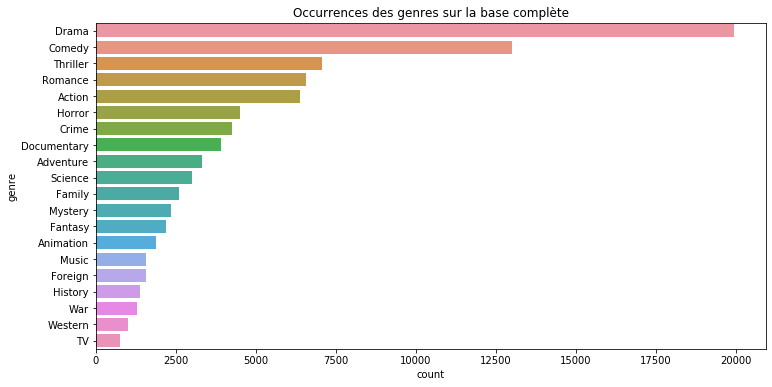

In [ ]:
df_genre.genre = df_genre.genre.str.replace(r',', '')
fig, ax = plt.subplots(figsize=(12,6))
sns.countplot(y = df_genre.genre, order = df_genre['genre'].value_counts().index)
plt.title('Occurrences des genres sur la base complète')

Le graphique ci-dessus, déjà présenté plus tôt, nous informe que les deux genres les plus représentés dans la base sont les comédies et les drames. Ce résultat est assez logique car ces types de films sont souvent donnés en complément d'un autre genre. A présent, étudions les films les mieux classés.

In [ ]:
df.vote_count

0        5415.0
1        2413.0
2          92.0
3          34.0
4         173.0
          ...  
45461       1.0
45462       3.0
45463       6.0
45464       0.0
45465       0.0
Name: vote_count, Length: 45466, dtype: float64

En regardant de plus près la variable *vote_count*, nous constatons que certains films comportent moins de 10 évaluations. Par conséquent, afin d'avoir une analyse plus fine de la base, nous allons étudier les genres les plus représentés sur les films les mieux notés selon le classement imdb, sous contrainte que suffisamment de personnes les aient évalués (plus de 100).

On construit donc "best movies" correspondant aux films ayant été notés par plus de 100 personnes et ayant une note supérieure à 7.0 qu'on compare à l'ensemble des films ayant été notés par plus de 100 personnes. 

In [ ]:
df.vote_average

0        7.7
1        6.9
2        6.5
3        6.1
4        5.7
        ... 
45461    4.0
45462    9.0
45463    3.8
45464    0.0
45465    0.0
Name: vote_average, Length: 45466, dtype: float64

In [ ]:
df_classement =df[df.vote_count>100].sort_values(by='vote_average', ascending = False)     # on filtre sur les films qui ont été notés au moins 100 fois
df_best_movies = df_classement[df_classement.genres != '']    # on filtre sur les films pour lesquels le genre est renseigné
df_best_movies = df_best_movies[df.vote_average >= 7.0]      # on filtre sur les "meilleurs films" ie avec un score supérieur à 7
df_best_movies.reset_index(drop = True)
print('La base contient',len(df_best_movies),'films très bien notés (>= 7.0)')

La base contient 1760 films très bien notés (>= 7.0)


/Users/h2jw/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
l = []
for i in trange(len(df_best_movies)):
    if type(df_best_movies.genres.iloc[i]) == str :
        bm_genre = df_best_movies.genres.iloc[i].split()
        for i in bm_genre :
            l.append(i)
print(len(l))
df_bm_genre = pd.DataFrame(l, columns=['genre'])
df_bm_genre.genre = df_bm_genre.genre.str.replace(r',', '')
df_bm_genre['best_movies']=['Best movies' for i in range(len(df_bm_genre))]

df_genre['best_movies']=['All movies' for i in range(len(df_genre))]


4303


In [ ]:
df_compare_genres = df_genre.append(df_bm_genre)

df_compare_genres.head()


genre best_movies
0  Animation  All movies
1     Comedy  All movies
2     Family  All movies
3  Adventure  All movies
4    Fantasy  All movies

Text(0.5, 1.0, 'Occurrences des genres des films les mieux notés vs occurrences de tous les genres ')

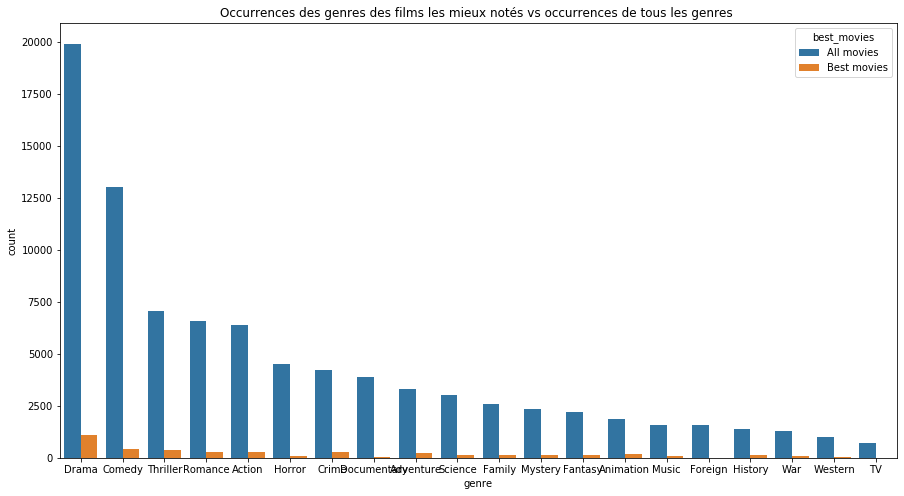

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
sns.countplot(x='genre', hue='best_movies', data=df_compare_genres, order=df_genre.genre.value_counts(normalize=True).index)

plt.title('Occurrences des genres des films les mieux notés vs occurrences de tous les genres ')

Un plot des observations des genres des films les mieux notés contre ceux de tous les films ne nous permet pas de conclure. On normalise donc tout cela pour faire apparaître la fréquence d'apparition des genres pour l'ensemble des films et pour les films les mieux notés. 

Text(0.5, 1.0, 'Proportion des genres dans les films les mieux notés et dans tous les films')

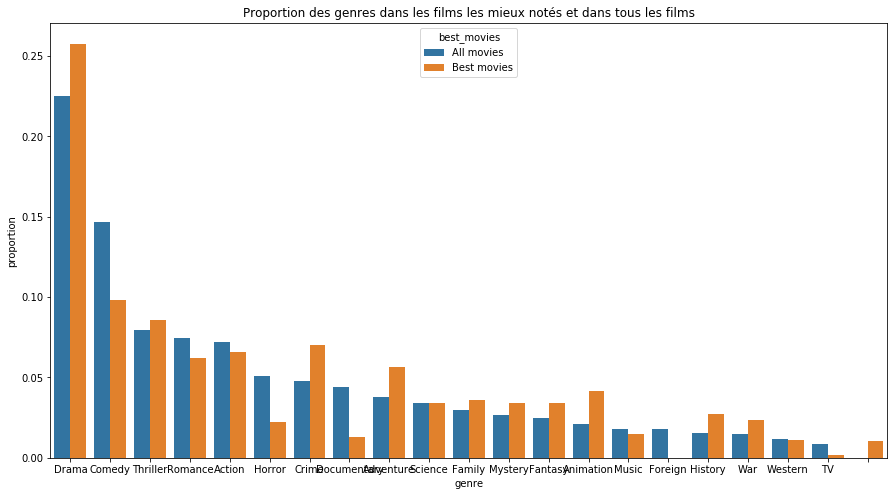

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
x, y, hue = "genre", "proportion", "best_movies"
(df_compare_genres[x].groupby(df_compare_genres[hue]).value_counts(normalize=True).rename(y).reset_index().pipe((sns.barplot, "data"), x=x, y=y, hue=hue))

plt.title('Proportion des genres dans les films les mieux notés et dans tous les films')


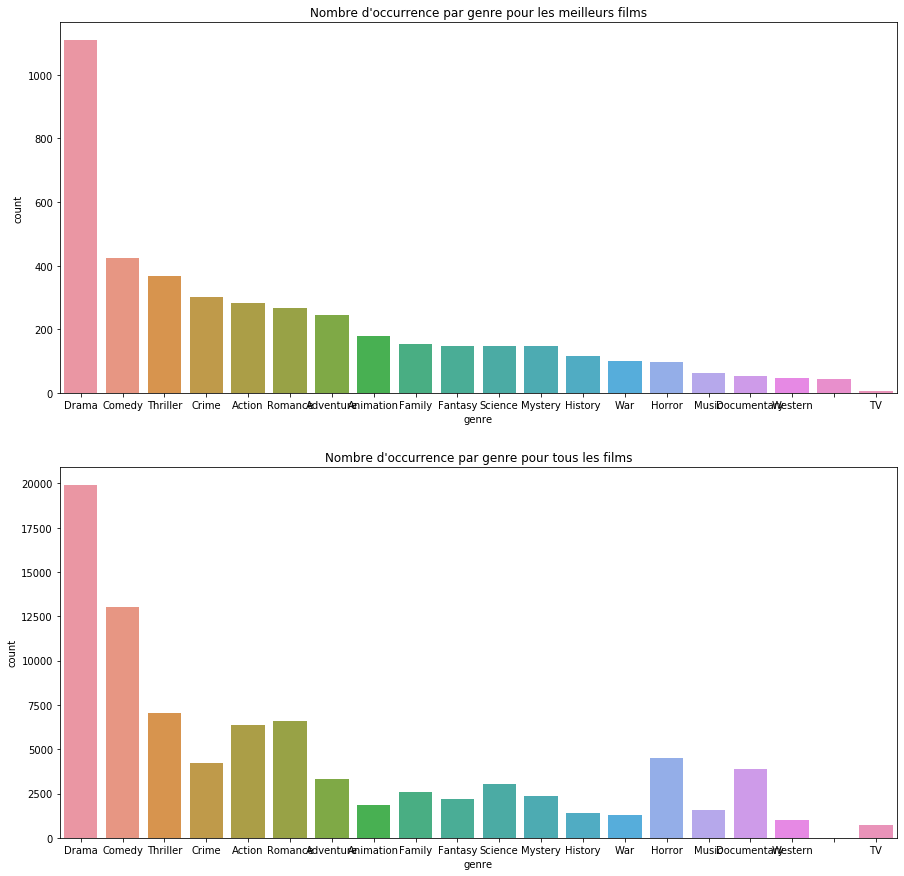

In [ ]:
fig, (ax_1, ax_2) = plt.subplots(2, figsize=(15,15))
sns.countplot(x = df_bm_genre.genre, order = df_bm_genre.genre.value_counts().index, ax = ax_1)
sns.countplot(x = df_genre.genre, order = df_bm_genre.genre.value_counts().index,ax=ax_2)
ax_1.title.set_text("Nombre d'occurrence par genre pour les meilleurs films")
ax_2.title.set_text("Nombre d'occurrence par genre pour tous les films")

Nous remarquons que la tendance est sensiblement la même. En effet, avec environ plus de 18 000 films dramatiques, il est assez normal de trouver un bon nombre de films bien notés dans cet ensemble.

Toutefois, on constate que bien que certains genres de films soient très présents dans la base, ils peuvent apparaître moins souvent dans le classement des meilleurs films. 

En effet, alors que le genre Romance était le 3ème genre le plus présent, ici nous remarquons qu'il apparaît beaucoup plus loin dans le classement des genres les plus représentés dans les films les mieux notés (6e position). A l'inverse, le genre Crime est le 4 ème genre le plus représenté dans l'échantillon, et gagne alors 2 places par rapport à son classement dans l'échantillon initial.

Ces observations nous amènent donc à tenter d'établir un score prenant à la fois en compte le score du vote et la popularité (peut-être reflétée par le nombre de vote) des films. 

## Variables quantitatives

### Budget

Une simple recherche internet nous informe que les budgets les plus petits dans la conception d'un film (appelés films "micro-budgets") s'élèvent à quelques milliers de dollars. On peut regarder la distribution des films micro-budgets.

In [ ]:
len(df.budget[df.budget == 0])/len(df.budget)*100

80.44032903708266

In [ ]:
df.budget[df.budget < 10000].describe()

count    36873.000000
mean         8.133784
std        201.490942
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       9500.000000
Name: budget, dtype: float64

Pourcentage de microfilms (budget inférieur à 10000 dollars) à budget inférieurs à 1000 dollars :  99.85083936755892 %


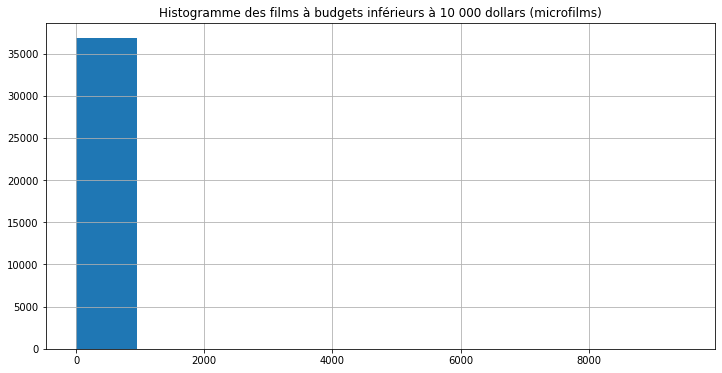

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
df.budget[df.budget < 10000].hist()
plt.title('Histogramme des films à budgets inférieurs à 10 000 dollars (microfilms)')

print('Pourcentage de microfilms (budget inférieur à 10000 dollars) à budget inférieurs à 1000 dollars : ', (len(df.budget[df.budget < 1000])/len(df.budget[df.budget < 10000]))*100,'%')

Au sein des microfilms (budget inférieur à 10000 dollars), on compte 99.85% de films à budget inférieur à 1000 euros. Ce nombre est de fait assez suspect, on peut imaginer que la base contient des 0 pour les valeurs de budget inconnues ainsi que la plupart des nombres entre 0 et 1000 dollars de production sont des outliers dûs à des erreurs de saisies. 

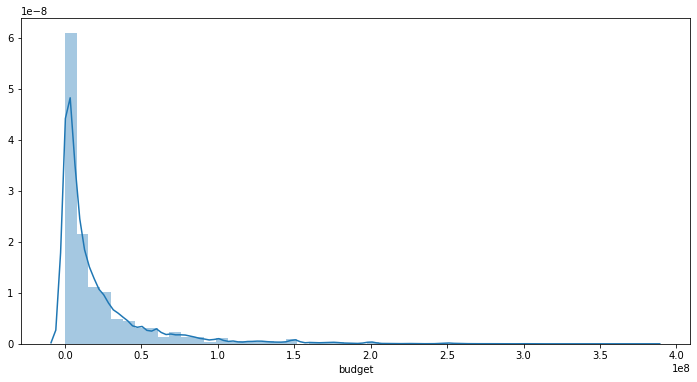

In [ ]:
df_budget_ecrete = df.budget[df.budget > 10000]
fig, ax = plt.subplots(figsize=(12,6))
ax = sns.distplot(df_budget_ecrete)
#ax.set_xscale('log')
#ax.set_yscale('log')

((array([-3.77240845, -3.54511026, -3.42022122, ...,  3.42022122,
          3.54511026,  3.77240845]),
  array([1.04e+04, 1.10e+04, 1.10e+04, ..., 2.80e+08, 3.00e+08, 3.80e+08])),
 (27726595.02718325, 22400462.640541162, 0.7991918566608214))

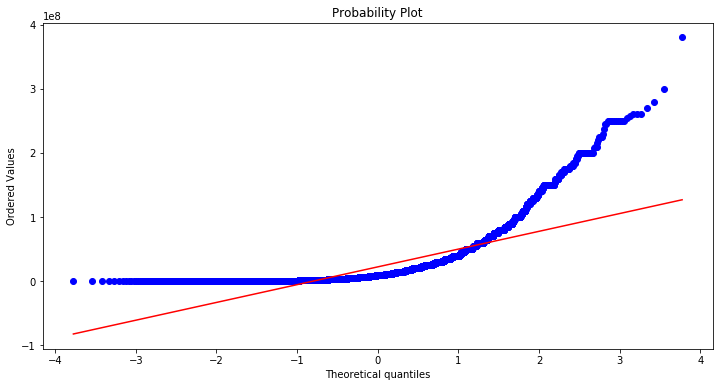

In [ ]:
from scipy import stats
import seaborn as sns
fig, ax = plt.subplots(figsize=(12,6))
stats.probplot(df_budget_ecrete, plot=sns.mpl.pyplot)

L'information sur le budget paraît peu exploitable du fait de la dispersion des données... Par conséquent, nous allons nous intéresser plus en détails aux revenus générés par le film.

### Revenus

## Statistiques sur les mots-clés

### Récupération de la base

In [ ]:
!ls

In [ ]:
with zipfile.ZipFile('base_keywords2.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('temp_dir')

In [ ]:
df_2 = pd.read_csv('temp_dir/base_keywords2.csv', sep=';', encoding = 'utf-8', nrows=45466, low_memory = False)
df_2
df_3 = df_2.copy()

A l'aide du package *wordcloud*, nous allons pouvoir créer des nuages de mots.

In [ ]:
def nuage_de_mots(text): 
    fig, ax = plt.subplots(figsize=(15,10))
    wordcloud = WordCloud(background_color="white",
                          relative_scaling = 1.0,
                          width=1280, 
                          height=800, 
                          stopwords = {'on', 'in', 'at', 'the', 'to', 'of', 'by', '_None', '_', 'NoNe','a'} # mots à ne pas prendre en compte dans le nuage
                          ).generate(text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()    

Pour produire des nuages de mots qualitatifs, nous nous sommes rendu compte qu'il fallait que l'algorithme puisse comprendre que chaque élément de *df_2.keywords[i]* correspond à un seul et unique mot-clé. Autrement, nous pourrions voir apparaître dans le nuage de mots à la fois 'new york' et 'york city'.

Par conséquent, nous allons traiter les données de manière astucieuse en utilisant plusieurs fois str.replace :

In [ ]:
print(df_2.keywords[0])

# On enlève les crochets et virgules et on les remplace par des tirets pour bien distinguer les mots-clés
df_2.keywords = df_2.keywords.str.replace(r'[^\w\s]', '-')
print(df_2.keywords[0])

# Les seuls espaces possibles se trouvent au sein d'un même mot-clé ou bien entre deux mots-clés distincts
df_2.keywords=df_2.keywords.str.replace(' ', '_')
print(df_2.keywords[0])

# On supprime les '-_-' qui ont été créés suite aux deux étapes précédentes
df_2.keywords = df_2.keywords.str.replace('-_-', '')
print(df_2.keywords[0])

# Désormais, les tirets sont la seule marque de ponctuation inutile
df_2.keywords = df_2.keywords.str.replace('-', ' ')
print(df_2.keywords[0])


['toy', 'rivalry', 'cowboy', 'cgi animation', 'claw crane', 'enemies become friends', 'toy comes to life', 'piggy bank', 'computer animation', 'dog', 'arcade game', 'two word title', 'birthday', "child's birthday", 'scene during opening credits', '1990s', 'dinosaur', 'suburb', "child's birthday party", 'birthday present', 'family relationships', 'jealousy', 'action figure', 'birthday party', 'anthropomorphism', 'brat', 'threat', 'magic 8 ball', 'directorial debut', 'toy dinosaur', 'falling out a window', 'toy soldier', 'first part', 'spaceman toy', 'friend', 'mr potato head', 'wilhelm scream', 'slinky dog', 'blockbuster', 'single mother', 'surprise ending', 'bo peep character', 'buzz lightyear character', 'woody character', 'poster', 'wallpaper', 'thunderstorm', 'talking toy', 'toy animal', 'gift', 'squeeze toy', 'bedroom', 'computer generated imagery', 'boy', 'toy story', 'anthropomorphic toy', "child's bedroom", 'scene before opening credits', "character's point of view camera shot",

--toy-rivalry-cowboy-cgi_animation-claw_crane-enemies_become_friends-toy_comes_to_life-piggy_bank-computer_animation-dog-arcade_game-two_word_title-birthday-child-s_birthday-scene_during_opening_credits-1990s-dinosaur-suburb-child-s_birthday_party-birthday_present-family_relationships-jealousy-action_figure-birthday_party-anthropomorphism-brat-threat-magic_8_ball-directorial_debut-toy_dinosaur-falling_out_a_window-toy_soldier-first_part-spaceman_toy-friend-mr_potato_head-wilhelm_scream-slinky_dog-blockbuster-single_mother-surprise_ending-bo_peep_character-buzz_lightyear_character-woody_character-poster-wallpaper-thunderstorm-talking_toy-toy_animal-gift-squeeze_toy-bedroom-computer_generated_imagery-boy-toy_story-anthropomorphic_toy-child-s_bedroom-scene_before_opening_credits-character-s_point_of_view_camera_shot-famous_line-first_of_series-astronaut-cowboy_doll-dog_as_gift-pet_as_gift-mother_son_relationship-reference_to_marie_antoinette-commercial-christmas_present-toy_dog-bad_guy-mr

Il ne reste plus qu'à concaténer tous les mots-clés pour pouvoir lancer la fonction nuage_de_mots précédente.

In [ ]:
mots_cles = ''
for i in trange(len(df_2)):
  mots_cles = mots_cles + str(df_2.keywords[i])

In [ ]:
#mots_cles

Puis on affiche le nuage de mots correspondant à tous ces mots-clés.

KeyboardInterrupt: 

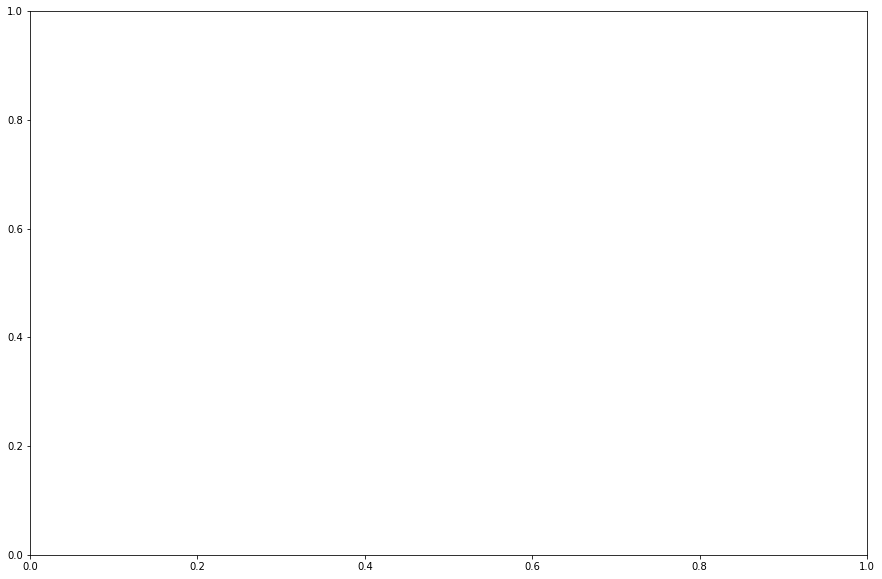

In [ ]:
nuage_de_mots(mots_cles)

Le nuage de mots ci-dessus retranscrit le nombre d'apparitions des mots-clés dans la base entière. Les trois mots qui correspondent au plus grand nombre de films sont 'violence', 'mort' et 'assassinat'. Cependant, si ces mots apparaissent souvent, c'est parce qu'ils se retrouvent dans de nombreuses catégories, telles que Thrillet, Action, Horreur et Drame. Par conséquent, pour avoir plus de précisions sur la fréquence d'apparition des mots-clés, nous allons nous intéresser à ceux qui reviennent le plus au sein des meilleurs films d'un genre

### Apparition des mots-clés en fonction du genre

Nous disposons déjà de la liste des genres de films qui composent la base :

In [ ]:
liste_genre = list(df_genre.genre.unique())
liste_genre.remove(np.nan)
liste_genre

['Animation',
 'Comedy',
 'Family',
 'Adventure',
 'Fantasy',
 'Romance',
 'Drama',
 'Action',
 'Crime',
 'Thriller',
 'Horror',
 'History',
 'Science',
 'War',
 'Mystery',
 'Foreign',
 'Music',
 'Documentary',
 'Western',
 'TV']

Nous pouvons désormais récupérer les mots-clés dans un dictionnaire qui a pour clés les différents genres.

In [ ]:
dico_nuages = dict()
for movie_genre in tqdm(liste_genre):
  liste_movie_genre = ''
  for i in range (len(df_best_movies)):
    if str(movie_genre) in str(df_best_movies.genres.iloc[i]):
      keywords_movie = df_2.keywords[df_2.imdb_id == df_best_movies.imdb_id.iloc[i]]    # on récupère les mots-clés associés au film i du genre movie_genre 
      l = keywords_movie.to_string()                                                    # on doit convertir cette serie en string de la forme 'i   mots-clés'
      ll = l.split()
      if len(ll) > 1 :                                                                  # on vérifie que le film contient bien des mots-clés
        kw = ' '.join(ll[1:])                                                           # on convertit la liste précédemment créée en string
        liste_movie_genre += kw                                                         # on ajoute kw à la liste des mots-clés du genre
  dico_nuages[str(movie_genre)] = liste_movie_genre

Nuage de mots pour le genre Animation


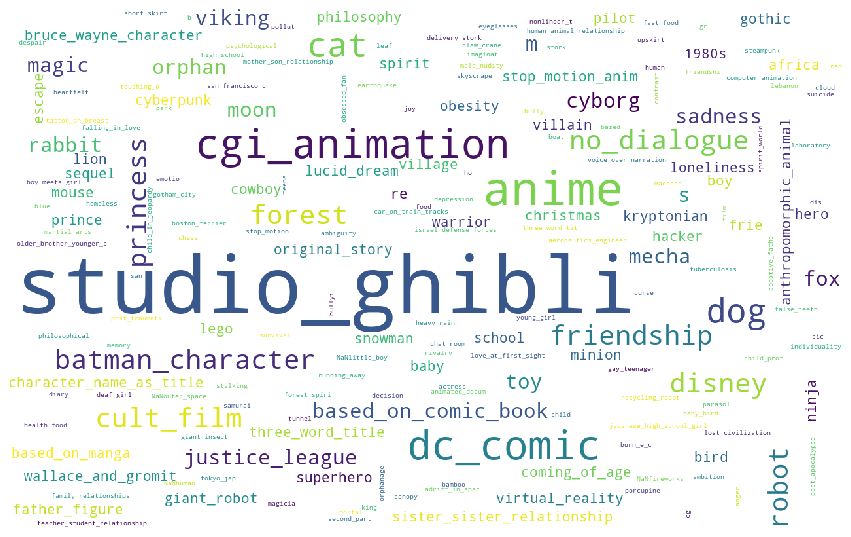

Nuage de mots pour le genre Comedy


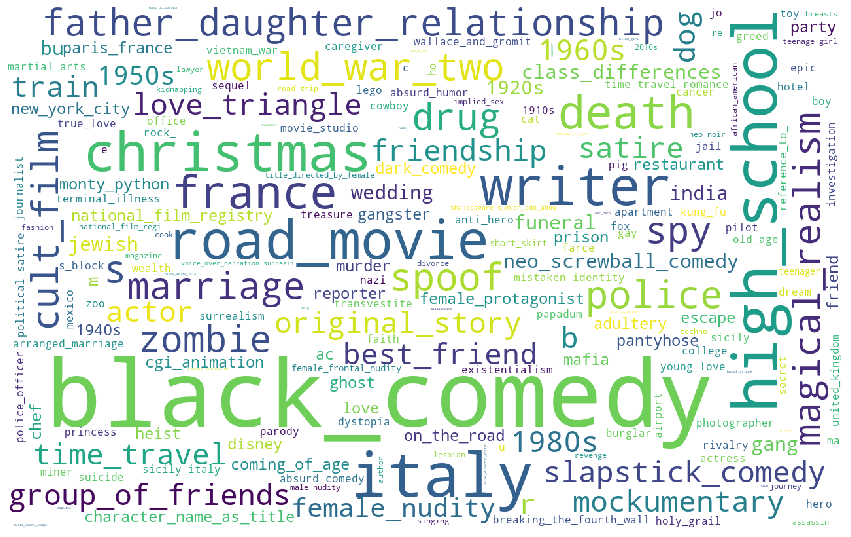

Nuage de mots pour le genre Family


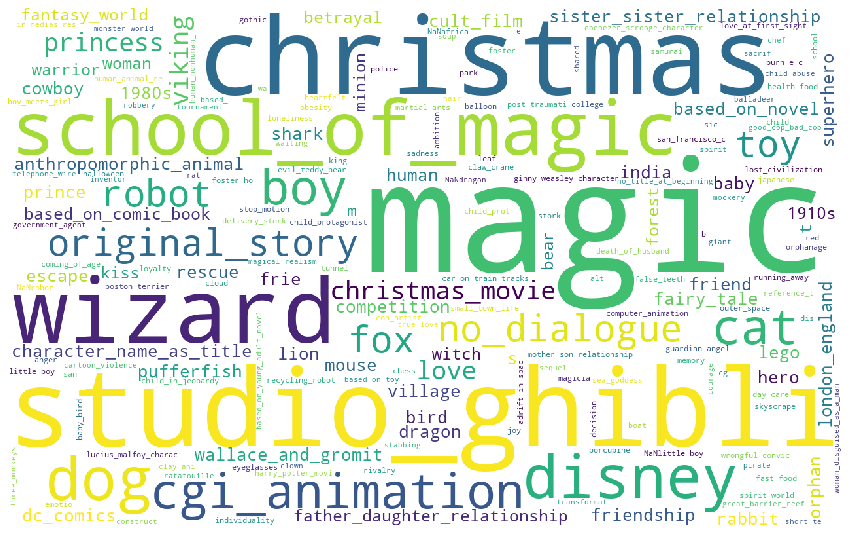

Nuage de mots pour le genre Adventure


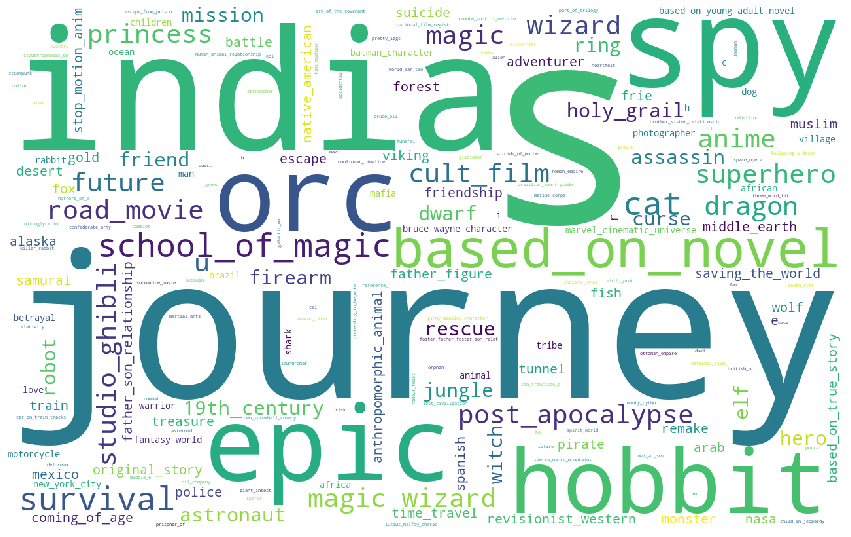

Nuage de mots pour le genre Fantasy


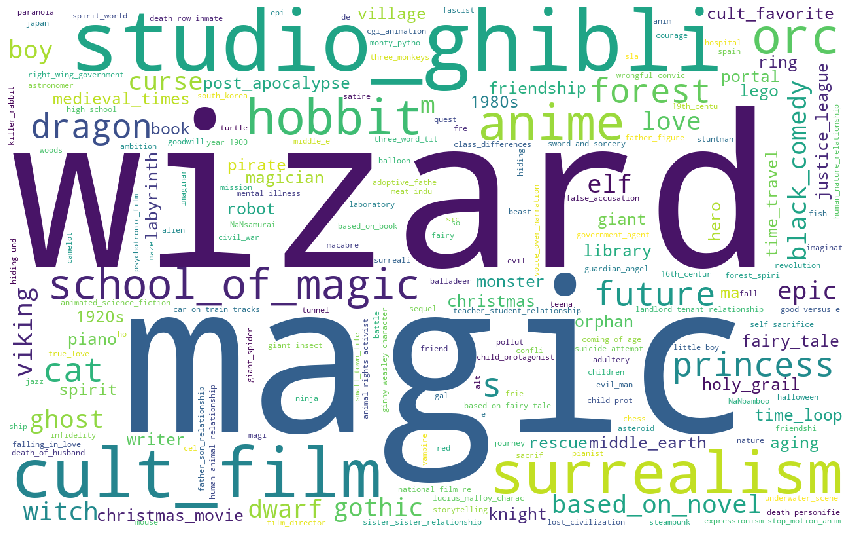

Nuage de mots pour le genre Romance


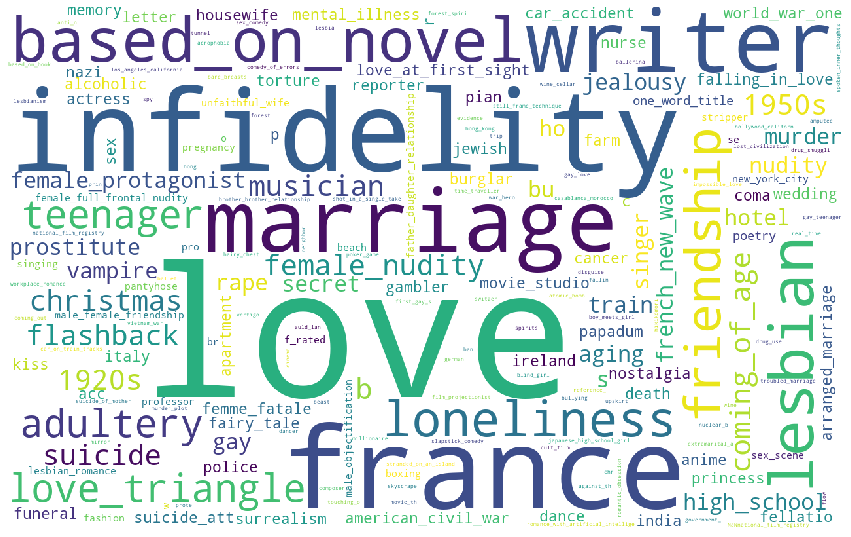

Nuage de mots pour le genre Drama


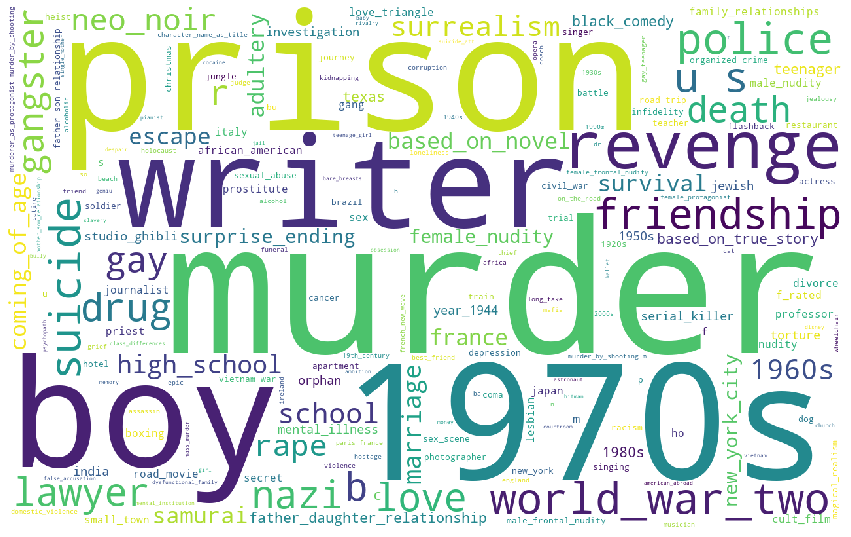

Nuage de mots pour le genre Action


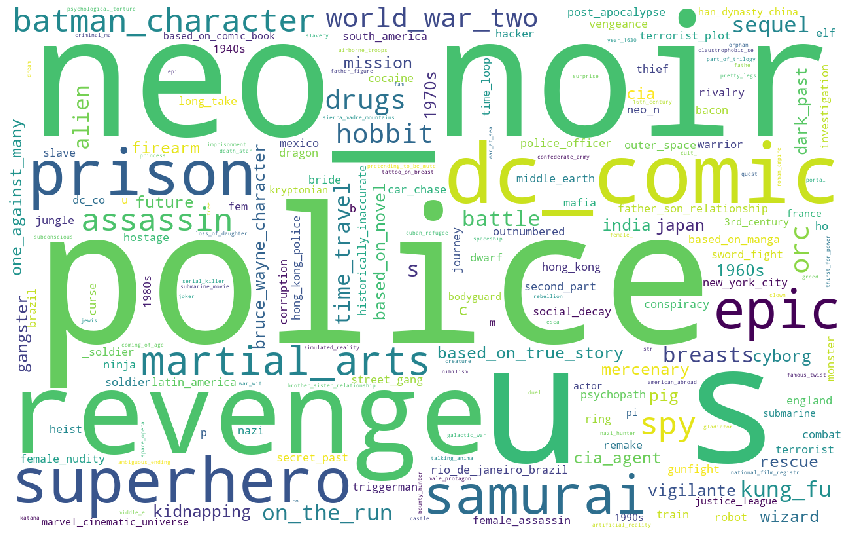

Nuage de mots pour le genre Crime


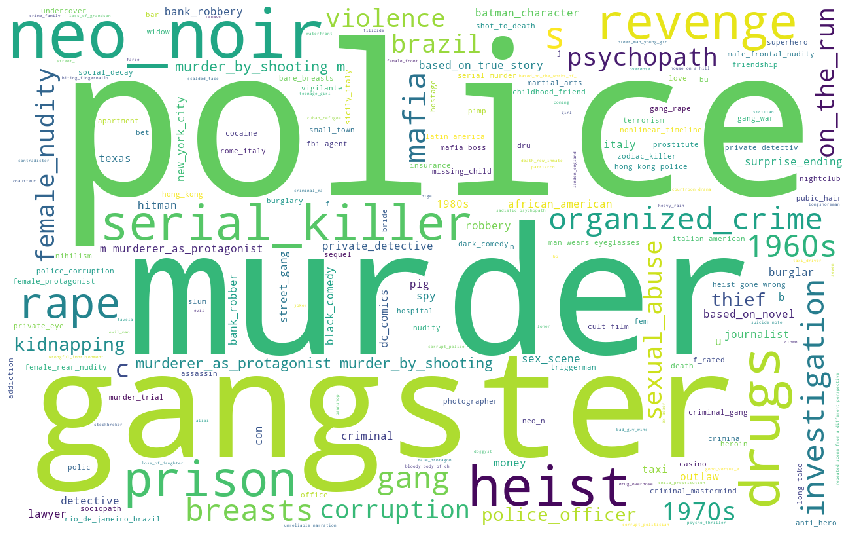

Nuage de mots pour le genre Thriller


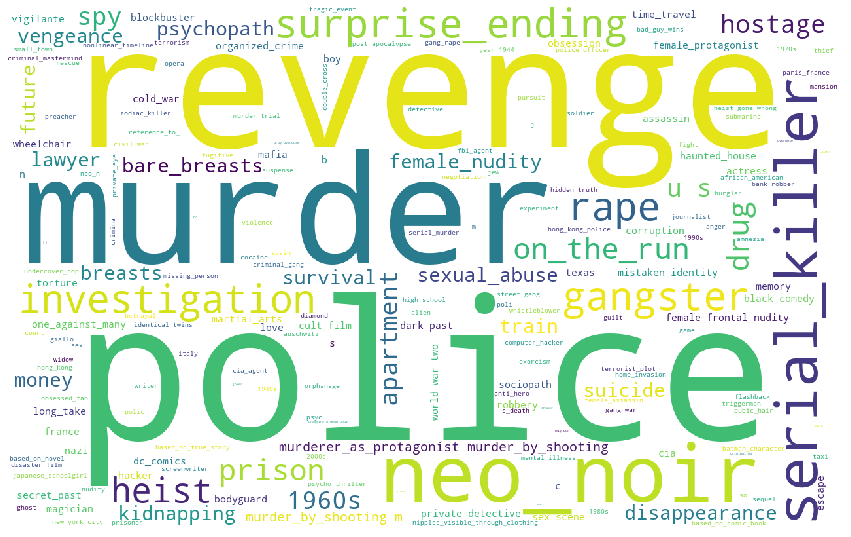

Nuage de mots pour le genre Horror


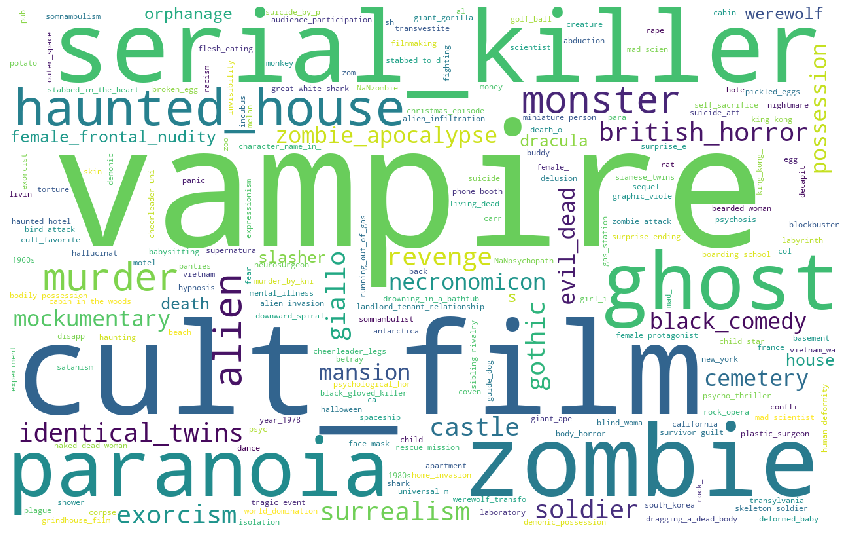

Nuage de mots pour le genre History


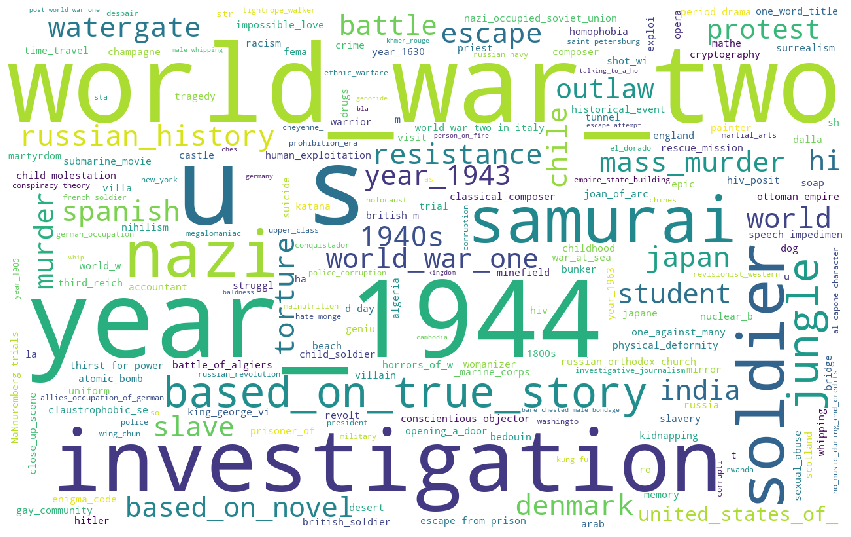

Nuage de mots pour le genre Science


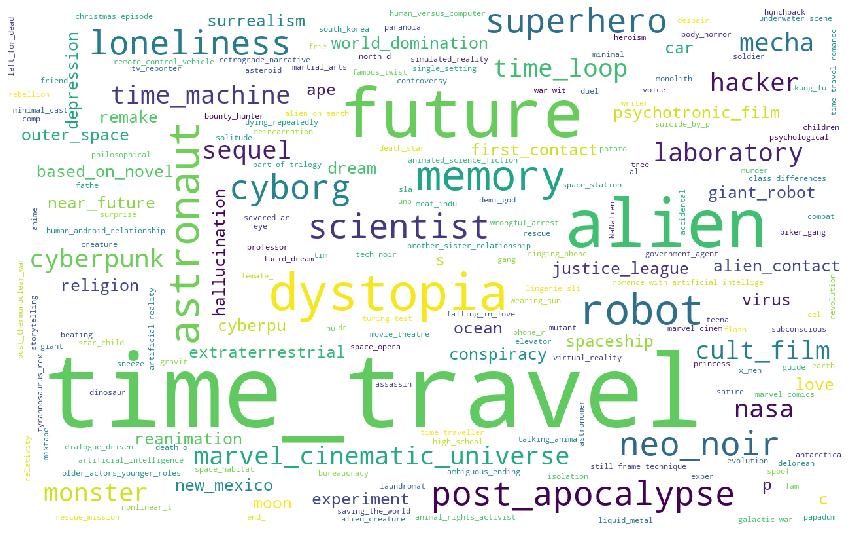

Nuage de mots pour le genre War


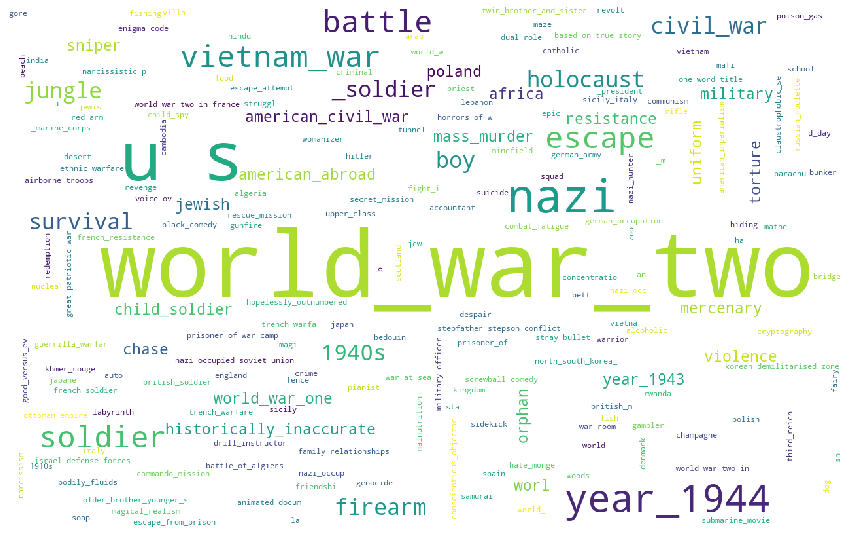

Nuage de mots pour le genre Mystery


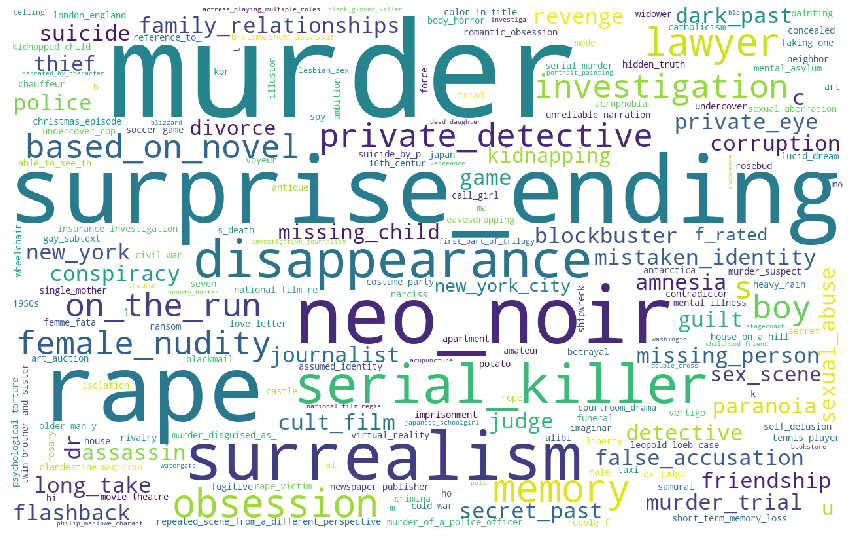

Nuage de mots pour le genre Music


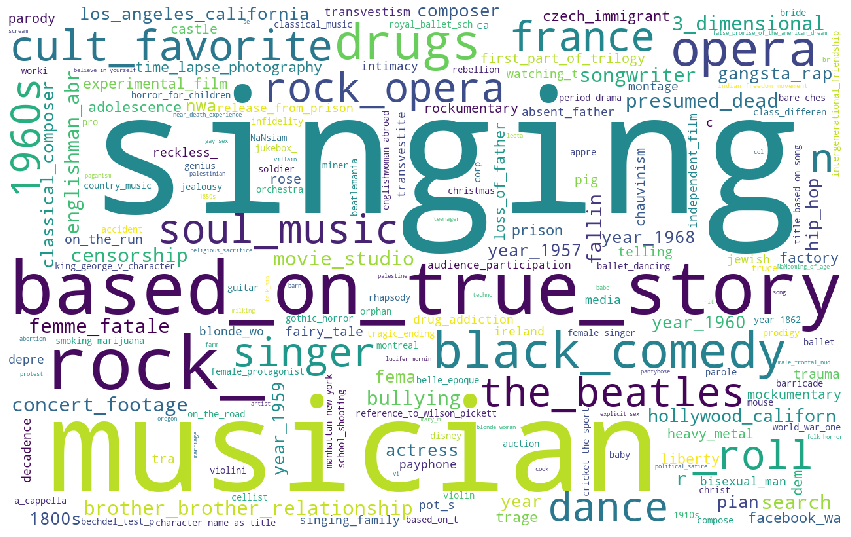

Nuage de mots pour le genre Documentary


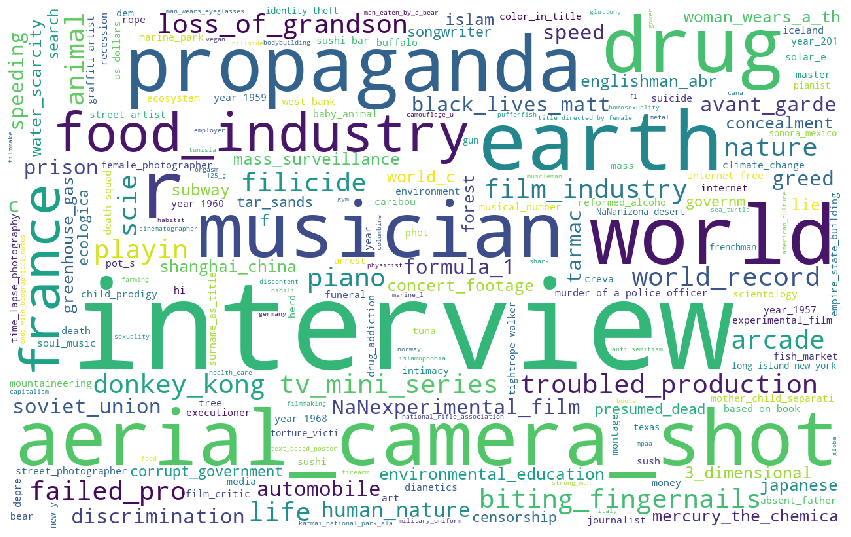

Nuage de mots pour le genre Western


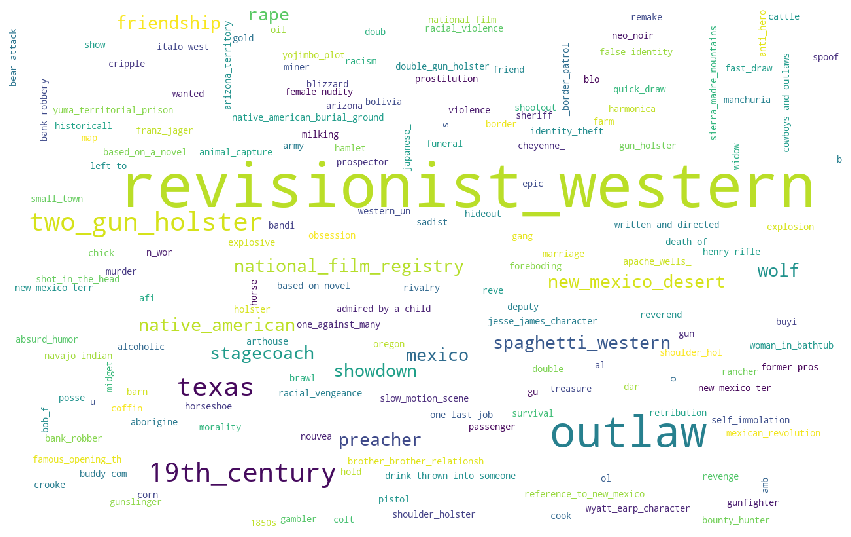

Nuage de mots pour le genre TV


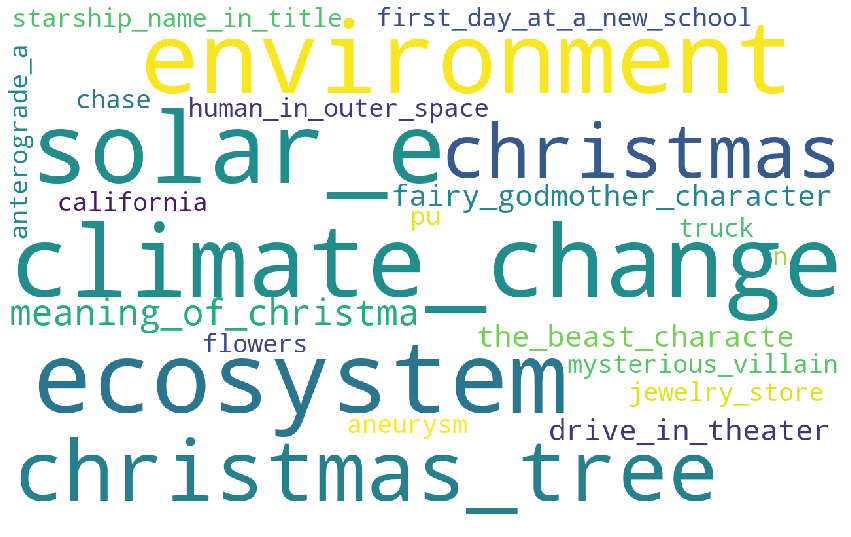

In [ ]:
for key in dico_nuages:
  if str(key) != 'Foreign':
    print('Nuage de mots pour le genre', key)
    nuage_de_mots(dico_nuages[str(key)])


Grâce à ces différents nuages de mots, nous pouvons déterminer quels mots-clés ressortent le plus dans les différents genres de films. Le résultat est assez cohérent. Néanmoins, pour les genres "Guerre" et "Western", les nuages de mots sont assez difficiles à lire dans la mesure où il y a très peu de mots-clés qui comportent beaucoup d'occurrences.

### Apparition des mots clefs pour les meilleurs films selon les scores utilisés 

On considère comme "meilleurs films" les 200 meilleurs films de chacun des 3 types de scores utilisés : on pourra choisir comme le meilleur score celui qui donne un nuage de mots plus homogène. 

# Modélisation

Une première modélisation que l'on peut essayer d'implémenter est de prédire le score d'un film (vote_average) à l'aide des informations telles que le genre, les mots clefs, les acteurs, le producteur du film, et le budget. 

In [ ]:
def nuage_de_mots_par_score(score):
    liste_film = df.sort_values(by=score, ascending=False)['original_title'].head(200).tolist()
    mots_cles = ''
    for i in trange(len(liste_film)):
        for movie in df_2.title :
            if str(liste_film[i]) in str(movie) :
                mots_cles = mots_cles + str(df_2.keywords[i])
    return nuage_de_mots(mots_cles)

#### Popularity 

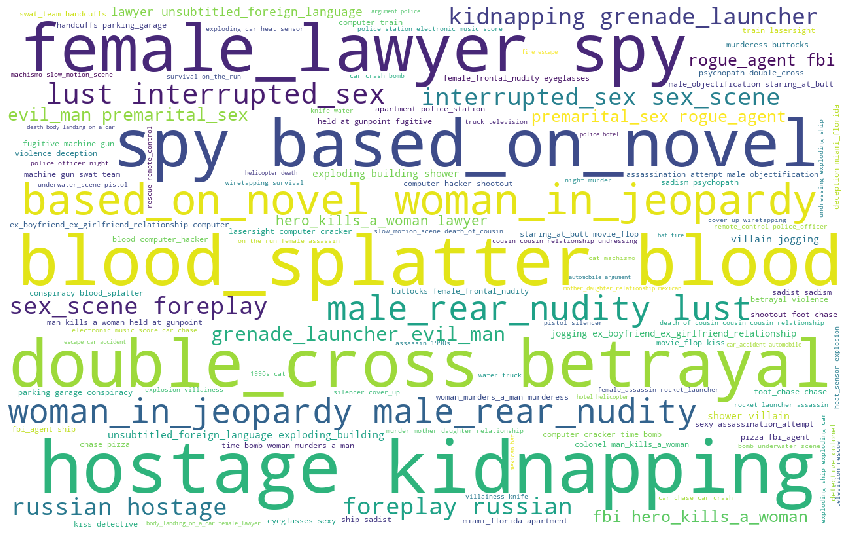

In [ ]:
nuage_de_mots_par_score('popularity')

#### Score_1 

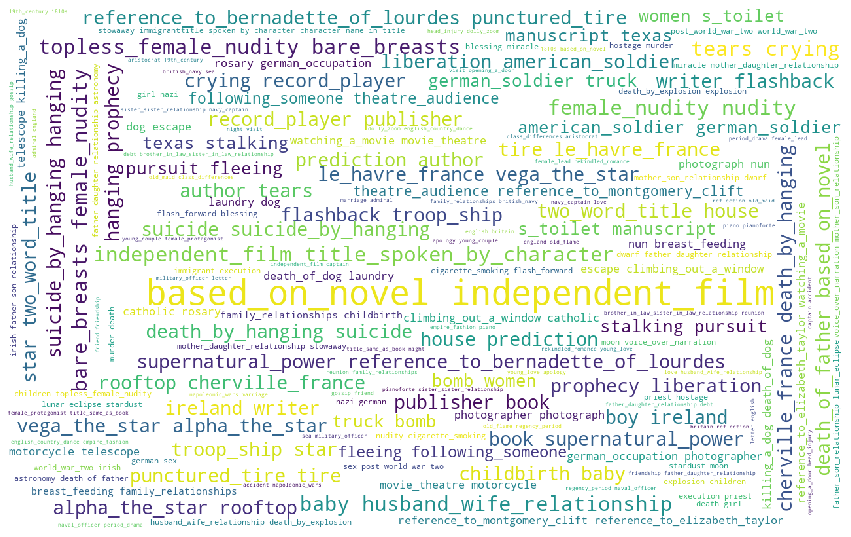

In [ ]:
nuage_de_mots_par_score('score_1')

#### Score et popularité

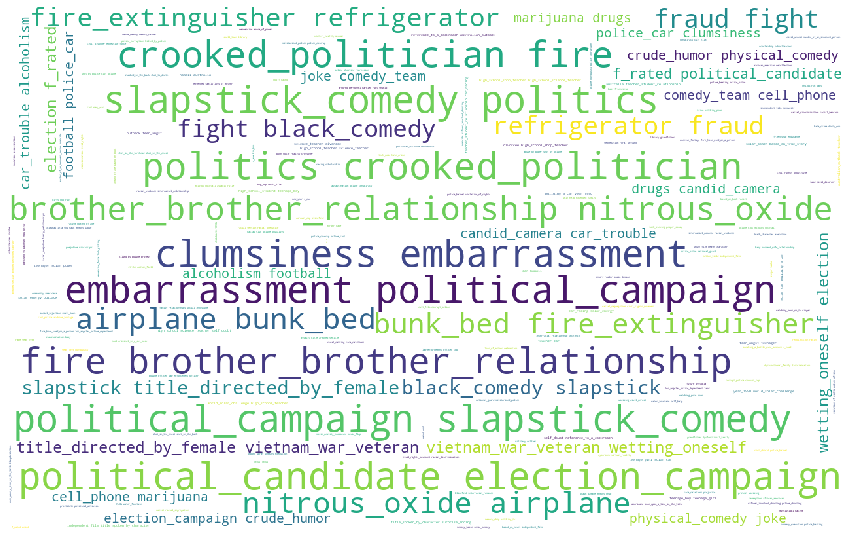

In [ ]:
nuage_de_mots_par_score('popscore')

Les deux premiers nuages de mots obtenus sont plus homogènes que le troisième avec un champ sémantique concentré sur les relations des personnages. 


In [ ]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)

import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/h2jw/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

On lemmatize puis préprocesse le texte des mots clefs. 

In [ ]:
stemmer = PorterStemmer()
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [ ]:
liste_film = df.sort_values(by='score_1', ascending=False)['original_title'].head(200).tolist()
mots_cles = ''
for i in trange(len(liste_film)):
    for movie in df_3.title :
        if str(liste_film[i]) in str(movie) :
            mots_cles = mots_cles + str(df_3.keywords[i])


In [ ]:

new_mots_cles = preprocess(mots_cles)

l_for_nuage = ''
for word in new_mots_cles : 
    l_for_nuage = l_for_nuage + ' ' + word 

In [ ]:
type(new_mots_cles[0])

str

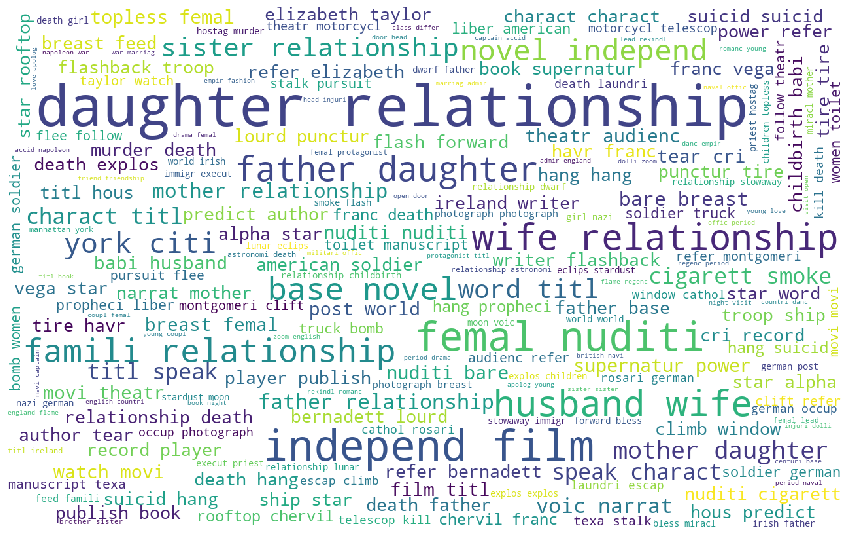

In [ ]:
nuage_de_mots(l_for_nuage)